In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

data_set = pd.read_csv('/content/drive/MyDrive/aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa/SriLanka_Weather_Dataset_updated (1).csv')

# Drop unnecessary columns
need_drop = ["temperature_2m_min","temperature_2m_max", "sunrise", "sunset", "apparent_temperature_min",
                "apparent_temperature_mean", "shortwave_radiation_sum", "rain_sum",
                "apparent_temperature_max","snowfall_sum","country"]
data_set.drop(columns=need_drop, inplace=True)

# List of cities
cities = ["Colombo", "Kandy", "Jaffna", "Galle"]

def preprocess_city_data(city_name, data):
    city_data = data[data["city"] == city_name]
    city_data[['time']] = city_data[['time']].apply(pd.to_datetime)
    city_data = city_data.set_index('time')

    # Create features and targets
    city_data["tomorrow_precipitation_sum"] = city_data["precipitation_sum"].shift(-1)
    city_data["tomorrow_temperature_sum"] = city_data["temperature_2m_mean"].shift(-1)
    city_data["tomorrow_precipitation_hours"] = city_data["precipitation_hours"].shift(-1)
    city_data["tomorrow_evapotranspiration"] = city_data["et0_fao_evapotranspiration"].shift(-1)

    # Fill missing values
    city_data["tomorrow_precipitation_sum"].fillna(city_data["precipitation_sum"], inplace=True)
    city_data["tomorrow_temperature_sum"].fillna(city_data["temperature_2m_mean"], inplace=True)
    city_data["tomorrow_precipitation_hours"].fillna(city_data["precipitation_hours"], inplace=True)
    city_data["tomorrow_evapotranspiration"].fillna(city_data["et0_fao_evapotranspiration"], inplace=True)

    # Drop unnecessary columns
    city_data.drop(columns=["weathercode", "city"], inplace=True)

    # Split into train and test
    train_data = city_data[city_data.index < '2017-12-31']
    test_data = city_data[city_data.index >= '2017-12-31']

    X_train = train_data.drop(columns=["tomorrow_precipitation_sum", "tomorrow_temperature_sum",
                                        "tomorrow_precipitation_hours", "tomorrow_evapotranspiration"])
    y_train_precip = train_data["tomorrow_precipitation_sum"]
    y_train_temp = train_data["tomorrow_temperature_sum"]
    y_train_precip_hours = train_data["tomorrow_precipitation_hours"]
    y_train_evapotranspiration = train_data["tomorrow_evapotranspiration"]

    X_test = test_data.drop(columns=["tomorrow_precipitation_sum", "tomorrow_temperature_sum",
                                      "tomorrow_precipitation_hours", "tomorrow_evapotranspiration"])
    y_test_precip = test_data["tomorrow_precipitation_sum"]
    y_test_temp = test_data["tomorrow_temperature_sum"]
    y_test_precip_hours = test_data["tomorrow_precipitation_hours"]
    y_test_evapotranspiration = test_data["tomorrow_evapotranspiration"]

    # Normalize
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_precip, y_test_precip, y_train_temp, y_test_temp, y_train_precip_hours, y_test_precip_hours, y_train_evapotranspiration, y_test_evapotranspiration

results = {}
for city in cities:
    X_train, X_test, y_train_precip, y_test_precip, y_train_temp, y_test_temp, y_train_precip_hours, y_test_precip_hours, y_train_evapotranspiration, y_test_evapotranspiration = preprocess_city_data(city, data_set)

    # Train Ridge Regression models for each variable
    ridge_precip = Ridge(alpha=0.1)
    ridge_precip.fit(X_train, y_train_precip)
    y_pred_precip = ridge_precip.predict(X_test)
    mae_precip = mean_absolute_error(y_test_precip, y_pred_precip)

    ridge_temp = Ridge(alpha=0.1)
    ridge_temp.fit(X_train, y_train_temp)
    y_pred_temp = ridge_temp.predict(X_test)
    mae_temp = mean_absolute_error(y_test_temp, y_pred_temp)

    ridge_precip_hours = Ridge(alpha=0.1)
    ridge_precip_hours.fit(X_train, y_train_precip_hours)
    y_pred_precip_hours = ridge_precip_hours.predict(X_test)
    mae_precip_hours = mean_absolute_error(y_test_precip_hours, y_pred_precip_hours)

    ridge_evapotranspiration = Ridge(alpha=0.1)
    ridge_evapotranspiration.fit(X_train, y_train_evapotranspiration)
    y_pred_evapotranspiration = ridge_evapotranspiration.predict(X_test)
    mae_evapotranspiration = mean_absolute_error(y_test_evapotranspiration, y_pred_evapotranspiration)

    results[city] = {
        'precipitation': {
            'mae': mae_precip,
            'y_true': y_test_precip,
            'y_pred': y_pred_precip
        },
        'temperature': {
            'mae': mae_temp,
            'y_true': y_test_temp,
            'y_pred': y_pred_temp
        },
        'precipitation_hours': {
            'mae': mae_precip_hours,
            'y_true': y_test_precip_hours,
            'y_pred': y_pred_precip_hours
        },
        'evapotranspiration': {
            'mae': mae_evapotranspiration,
            'y_true': y_test_evapotranspiration,
            'y_pred': y_pred_evapotranspiration
        }
    }

# Print results
for city, metrics in results.items():
    print(f"\nCity: {city}")
    print(f"Precipitation MAE: {metrics['precipitation']['mae']}")
    print(f"Temperature MAE: {metrics['temperature']['mae']}")
    print(f"Precipitation Hours MAE: {metrics['precipitation_hours']['mae']}")
    print(f"Evapotranspiration MAE: {metrics['evapotranspiration']['mae']}")


<ipython-input-3-0dd6721167ff>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[['time']] = city_data[['time']].apply(pd.to_datetime)
<ipython-input-3-0dd6721167ff>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[['time']] = city_data[['time']].apply(pd.to_datetime)
<ipython-input-3-0dd6721167ff>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 


City: Colombo
Precipitation MAE: 5.26468777675387
Temperature MAE: 0.3848721127162026
Precipitation Hours MAE: 3.9860558047805745
Evapotranspiration MAE: 0.4657231403187736

City: Kandy
Precipitation MAE: 5.568129986197546
Temperature MAE: 0.40776555338610293
Precipitation Hours MAE: 3.5905371556837737
Evapotranspiration MAE: 0.44858501126462247

City: Jaffna
Precipitation MAE: 3.299157114344162
Temperature MAE: 0.30746872258158736
Precipitation Hours MAE: 3.417800887659683
Evapotranspiration MAE: 0.4810599346649107

City: Galle
Precipitation MAE: 4.283750470309167
Temperature MAE: 0.4248273402896742
Precipitation Hours MAE: 4.360100166392259
Evapotranspiration MAE: 0.46385368389767534


<ipython-input-3-0dd6721167ff>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[['time']] = city_data[['time']].apply(pd.to_datetime)


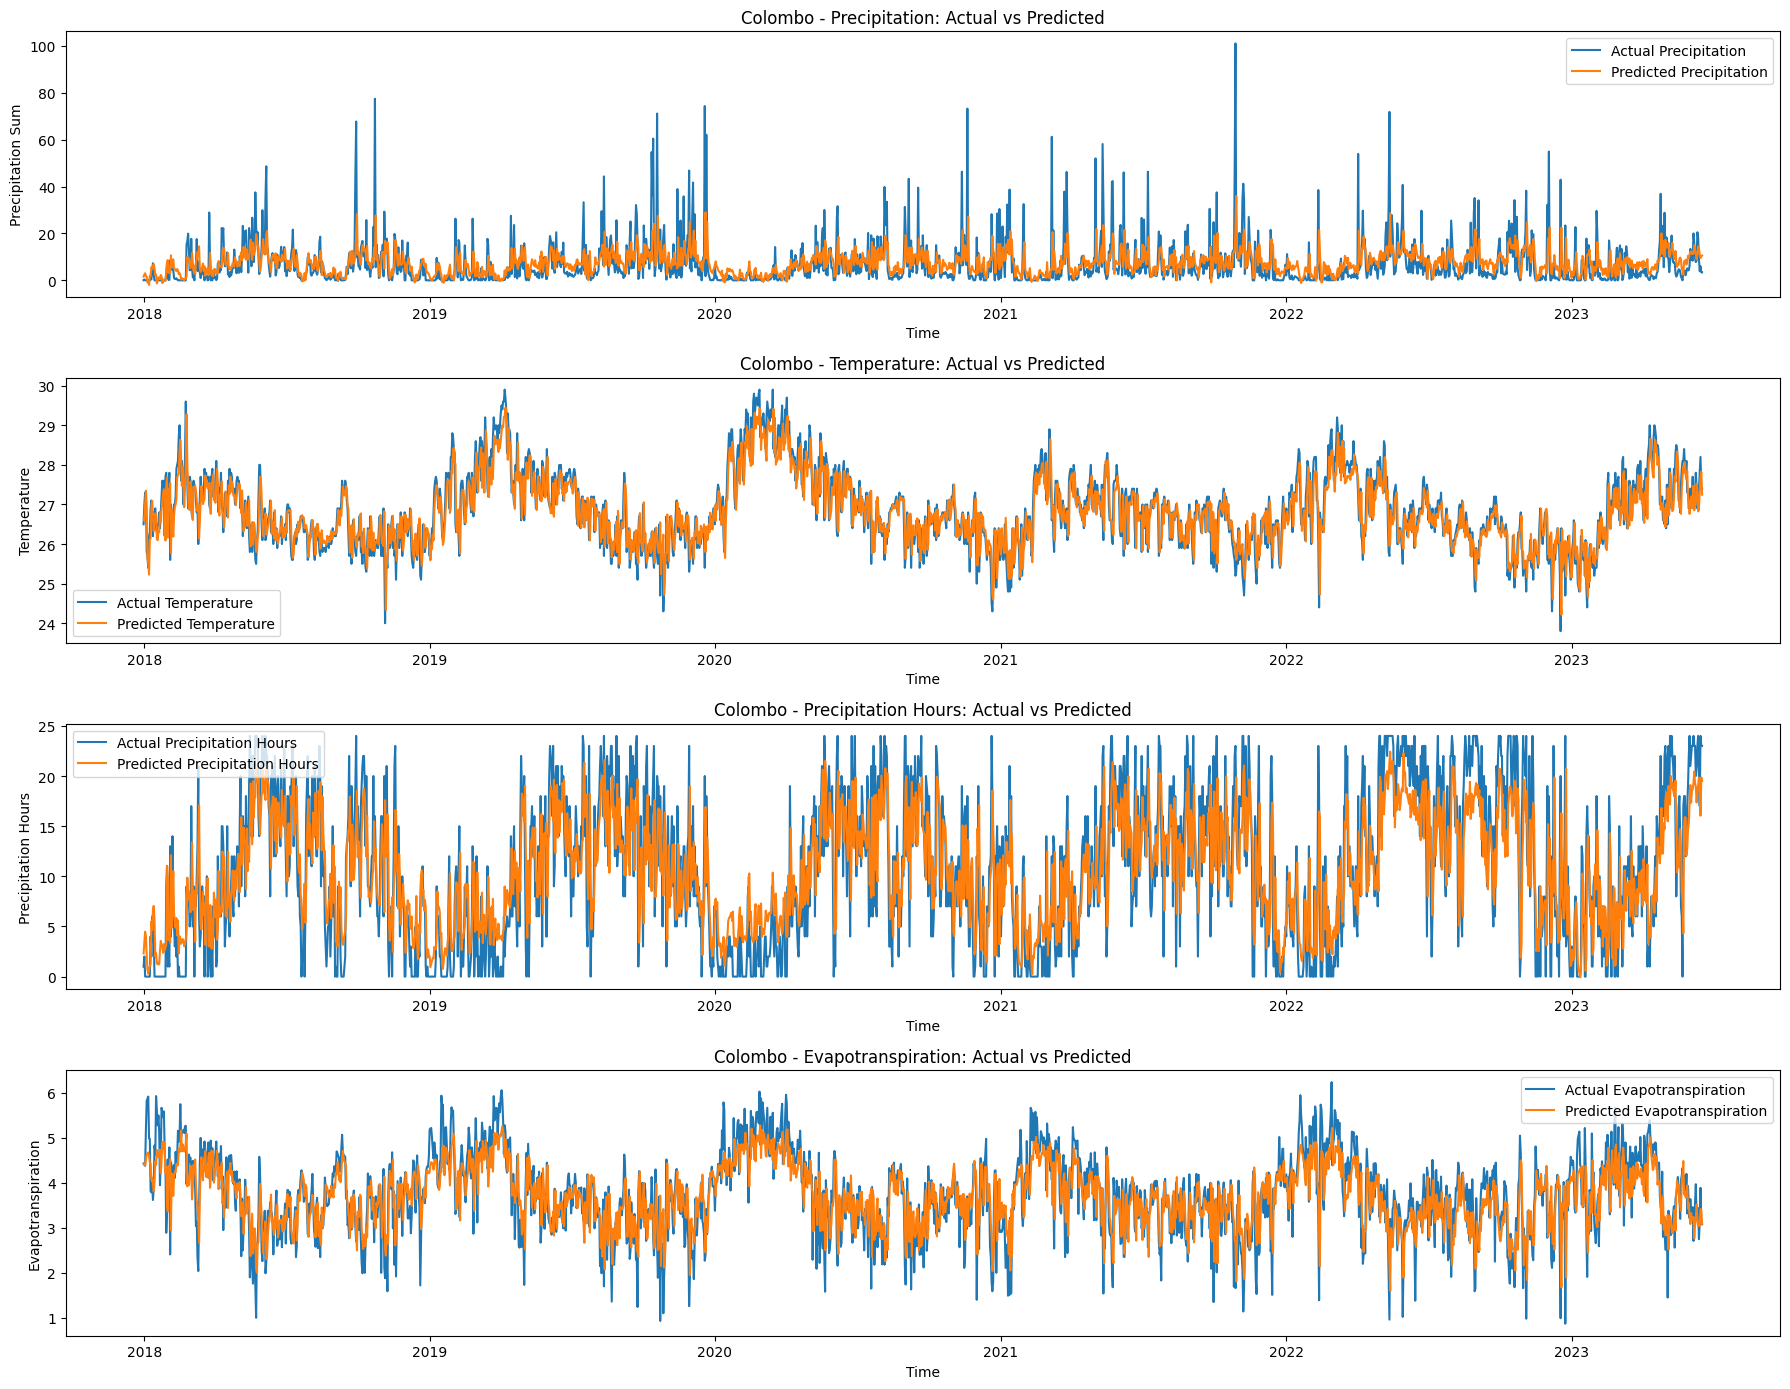

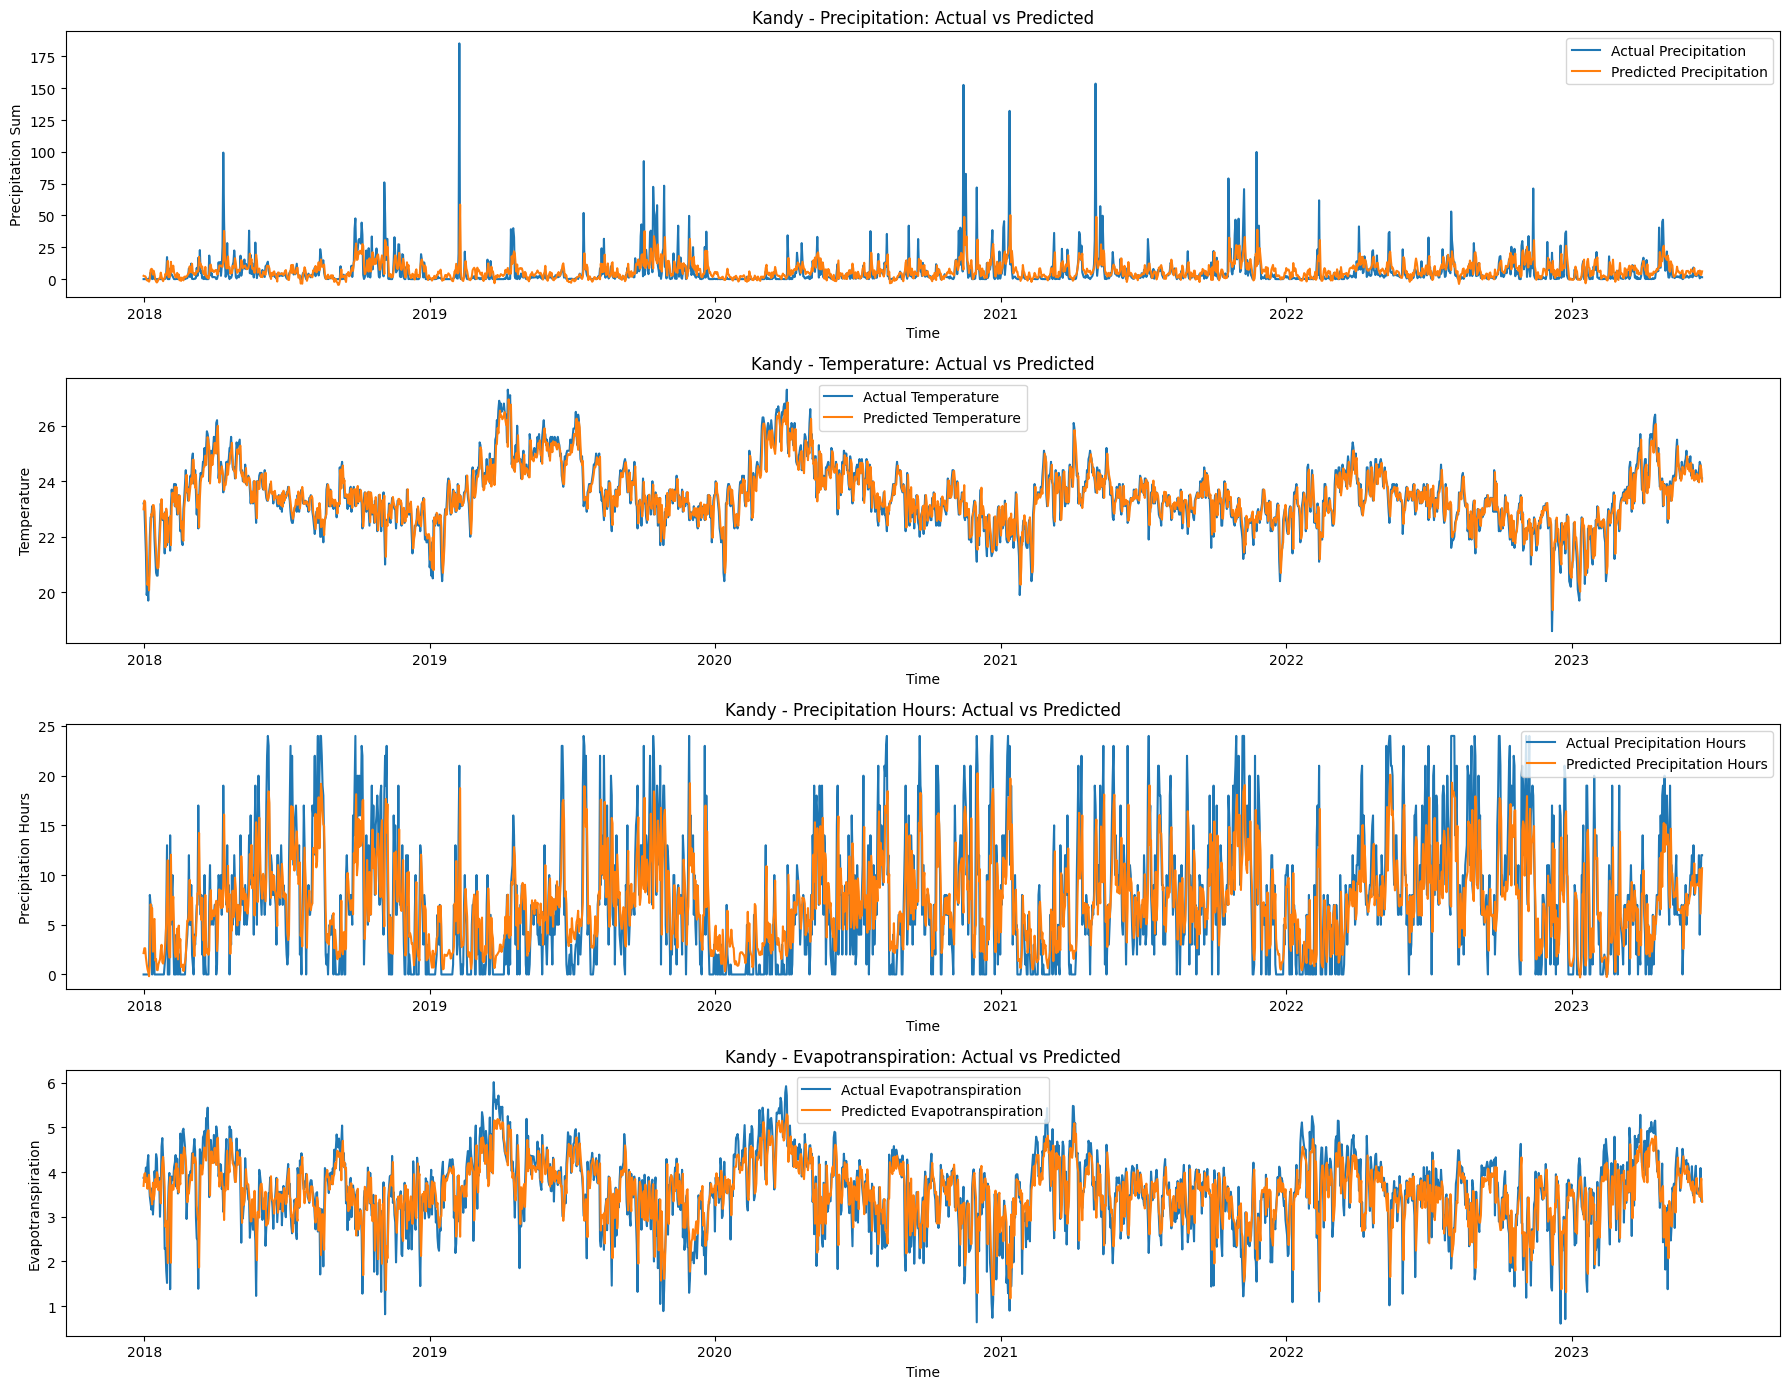

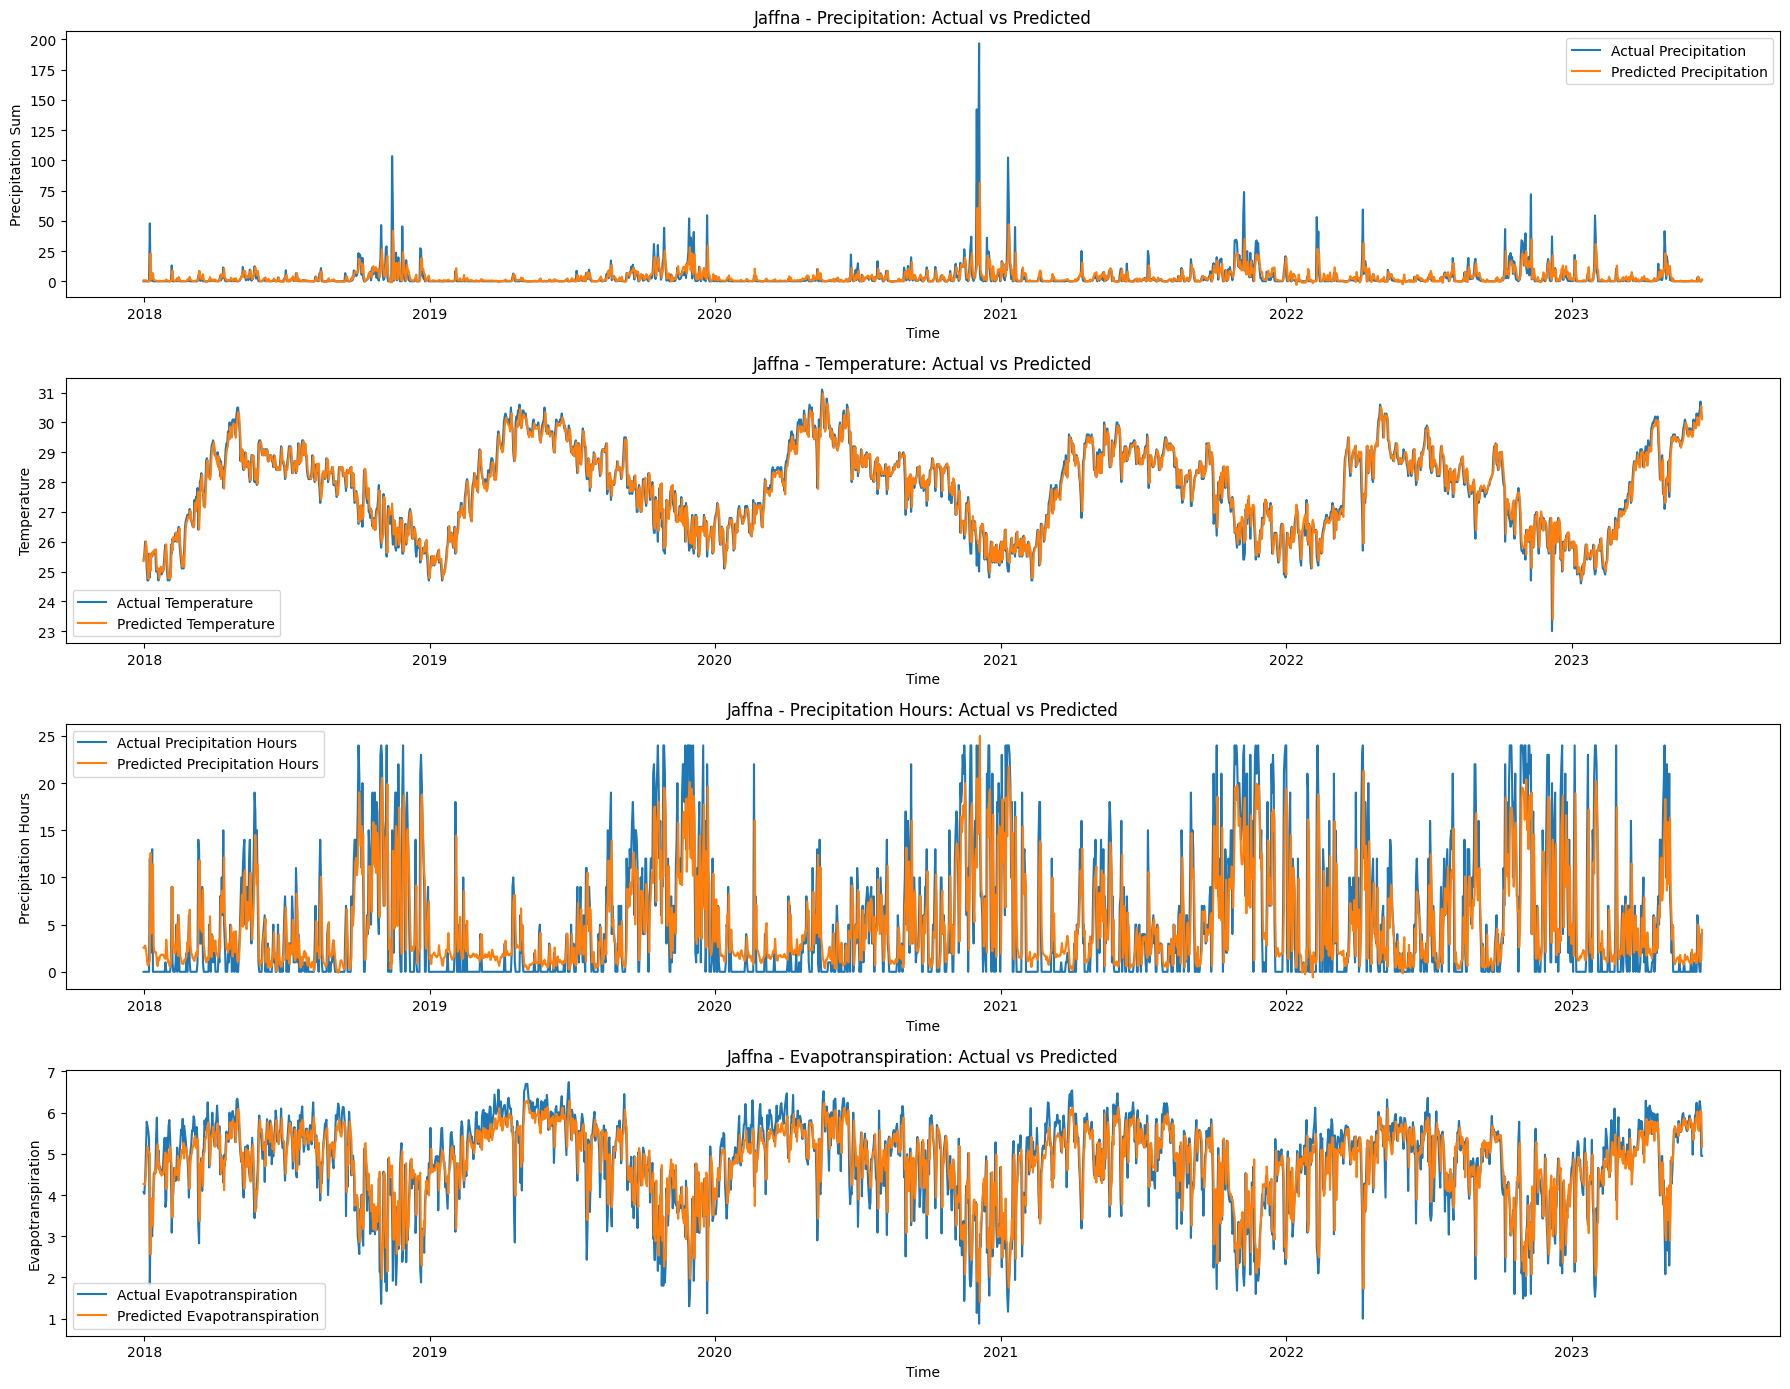

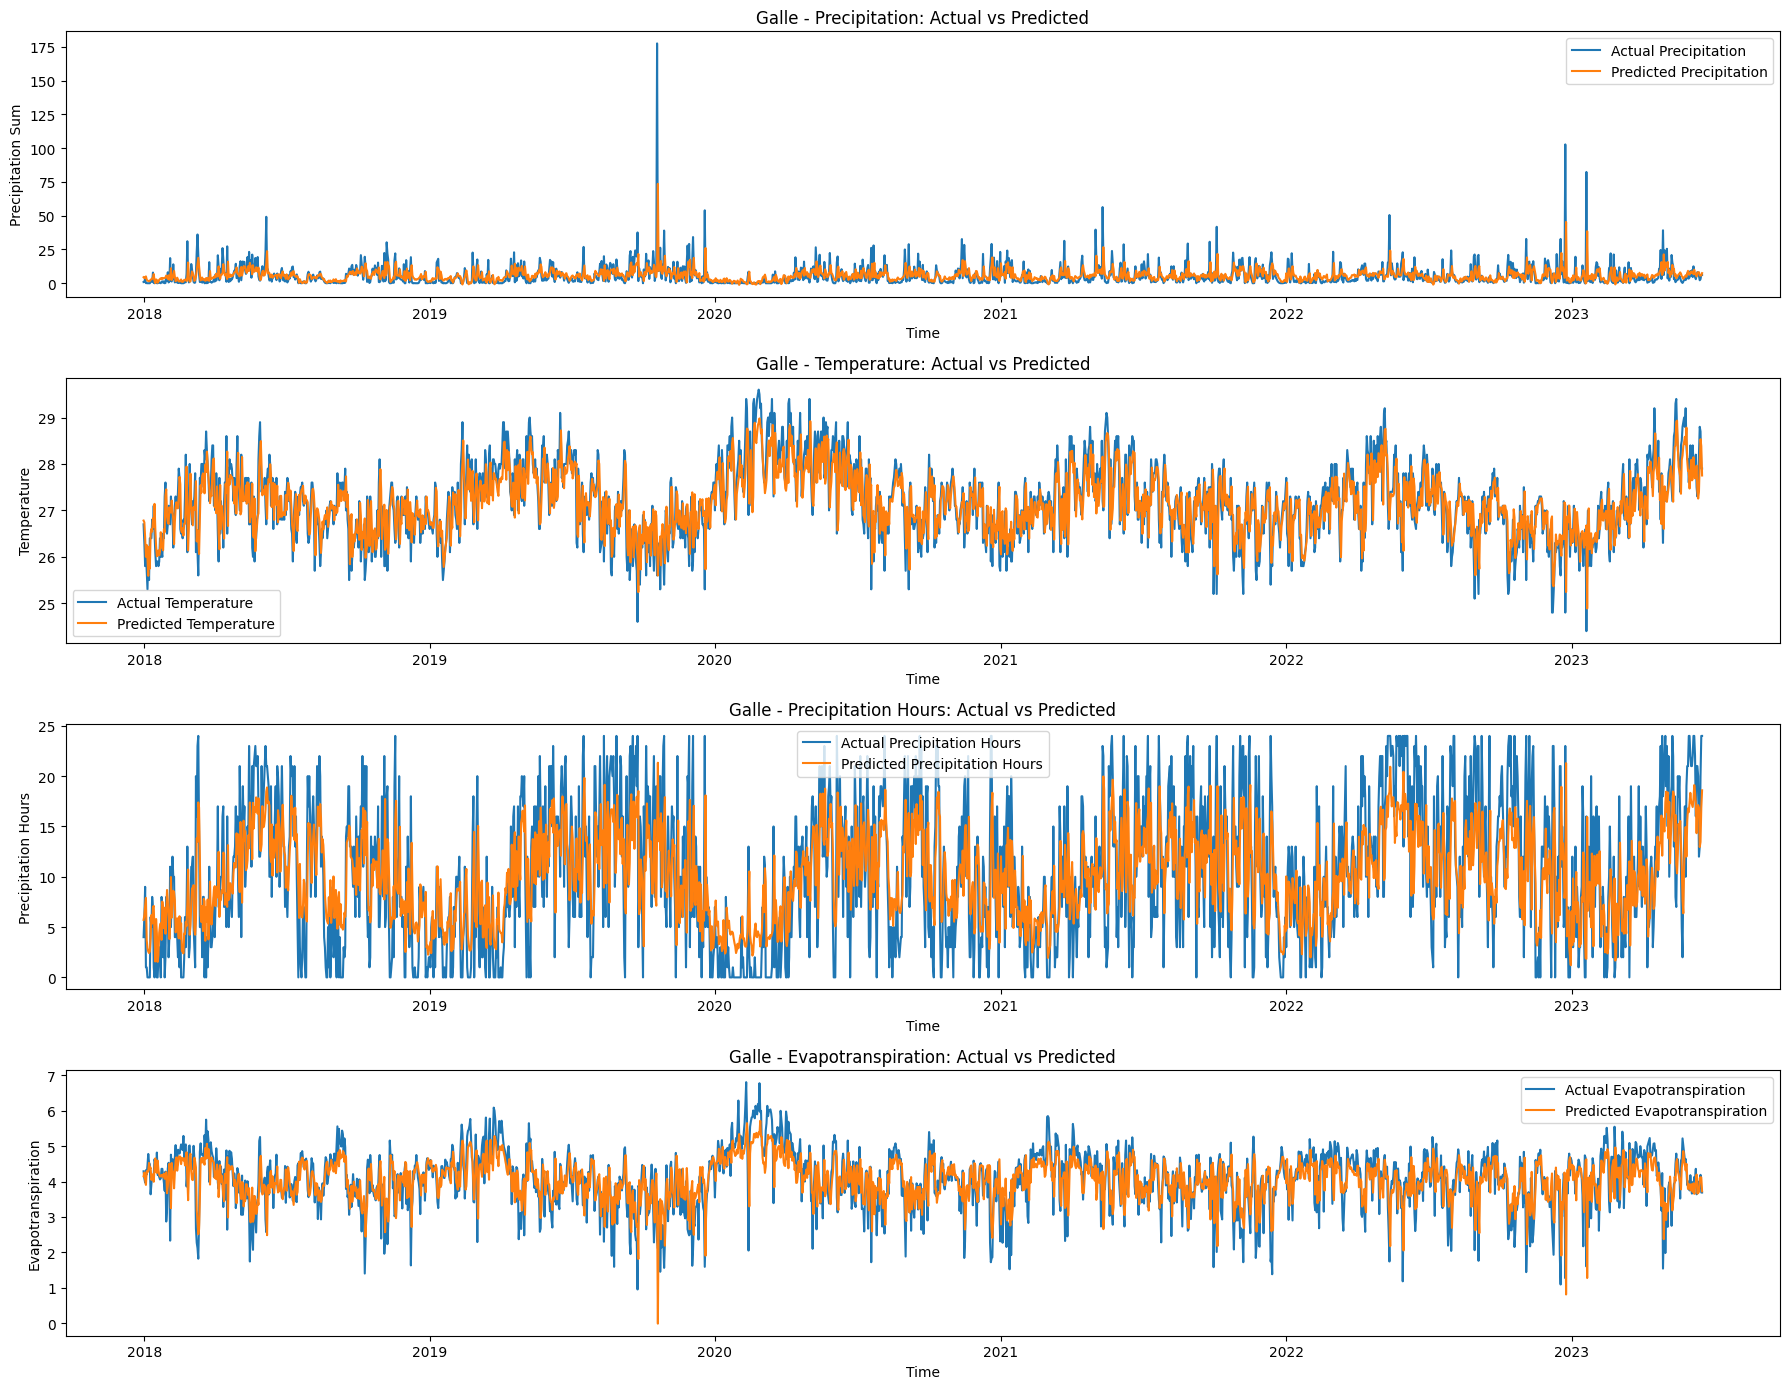

In [ ]:
for city, metrics in results.items():
    plt.figure(figsize=(18, 14))

    # Precipitation
    plt.subplot(4, 1, 1)
    plt.plot(metrics['precipitation']['y_true'].index, metrics['precipitation']['y_true'], label='Actual Precipitation')
    plt.plot(metrics['precipitation']['y_true'].index, metrics['precipitation']['y_pred'], label='Predicted Precipitation')
    plt.title(f'{city} - Precipitation: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Precipitation Sum')
    plt.legend()

    # Temperature
    plt.subplot(4, 1, 2)
    plt.plot(metrics['temperature']['y_true'].index, metrics['temperature']['y_true'], label='Actual Temperature')
    plt.plot(metrics['temperature']['y_true'].index, metrics['temperature']['y_pred'], label='Predicted Temperature')
    plt.title(f'{city} - Temperature: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Precipitation Hours
    plt.subplot(4, 1, 3)
    plt.plot(metrics['precipitation_hours']['y_true'].index, metrics['precipitation_hours']['y_true'], label='Actual Precipitation Hours')
    plt.plot(metrics['precipitation_hours']['y_true'].index, metrics['precipitation_hours']['y_pred'], label='Predicted Precipitation Hours')
    plt.title(f'{city} - Precipitation Hours: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Precipitation Hours')
    plt.legend()

    # Evapotranspiration
    plt.subplot(4, 1, 4)
    plt.plot(metrics['evapotranspiration']['y_true'].index, metrics['evapotranspiration']['y_true'], label='Actual Evapotranspiration')
    plt.plot(metrics['evapotranspiration']['y_true'].index, metrics['evapotranspiration']['y_pred'], label='Predicted Evapotranspiration')
    plt.title(f'{city} - Evapotranspiration: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Evapotranspiration')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
